# Example Notebook for learning to use dk-tools

This notebook holds a few examples of how to use the scripts in the dk-tools package. 

[//]: # "Note that this notebook has been paired with a python script file in the `percent` format using `jupytext`.  Use that file for comparing revisions. See [Collaborating on notebooks with git](https://github.com/mwouts/jupytext#collaborating-on-notebooks-with-git) for more details."

# Basic notebook stuff
You'll want to run these every time the notebook is opened or the kernel reset. All 3 are from StackOverflow, and I've tried to cite the original source, but I could have made a mistake.

In [1]:
import numpy as np
from itertools import chain

import scrolldown
%load_ext autoreload
%autoreload 2

# Helper for exit(), below
class StopExecution(Exception):
    def _render_traceback_(self):
        pass


# This function lets you stop a notebook cell without causing an error or quitting the kernel
# From https://stackoverflow.com/a/56953105
def exit():
    raise StopExecution


# I believe this came from https://stackoverflow.com/a/953097
def flatten_list(deep_list: list[list[object]]):
    return list(chain.from_iterable(deep_list))


# This function rounds numbers to the provided number of significant figures
# There are better options now, like numpy.format_float_scientific
# and so this is kept for legacy purposes
# I believe it's a modified version of https://stackoverflow.com/a/38362362
from typing_extensions import deprecated
@deprecated
def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p - 1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
# Needed to set these to display animations in the notebook. You might not need them.
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150

# Loading and plotting example

Loading a run:

In [3]:
from dk_tools.rundata import RunData

rd = RunData('example/example')
rd

Plotting an _n_ vs _T_ phase plot

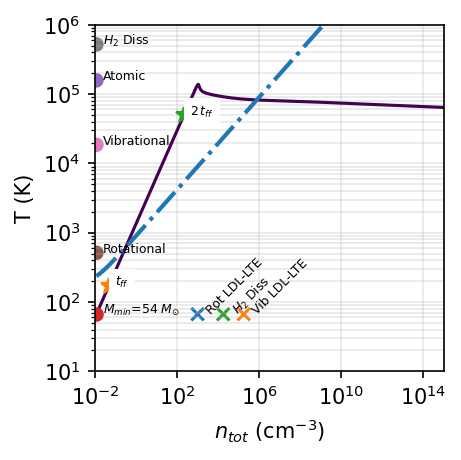

In [4]:
ax = rd.plot()
ax.figure.set_size_inches(3,3)

Plotting a number densities plot

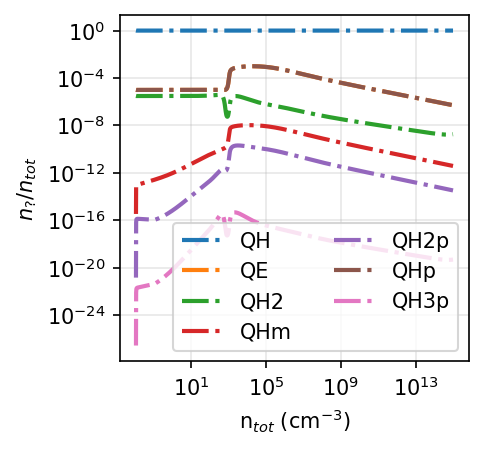

In [5]:
ax,_ = rd.plotNumberDensities()
ax.figure.set_size_inches(3,3)

# Regenerating the Halo Cooling paper plot
In the following few cells, we demonstrate how to obtain the plot from the cooling paper

First, we want to check that darkkrome is set up correctly

In [6]:
from dk_tools.darktestrunner import DarkTestRunner
from dk_tools.rundata import RunData
from pathlib import Path

rd = RunData('example/example')
opts = rd.opts

# You'll need to change this to wherever dk-tools is
opts.outdir = Path('halo').expanduser()

# You'll need to change this to wherever darkkrome is
dtr = DarkTestRunner(dkpath='/home/strato/workspace/Research/darkkrome')
outfile = dtr.run(opts=opts)
rd = RunData(opts.outdir/outfile)
rd

Second, we'll run an rm, rM grid with the same setup as in the Halo cooling plot. Note that this code takes a **long** time to run (~3 hrs on my machine, can't easily parallelize the compilation), so you'll want to **run it only once**.

In [7]:
from pathlib import Path

# You'll need to change this to wherever dk-tools is
outdir = Path('halo').expanduser()

rmrange = np.logspace(np.log10(0.07),2,25)
rMrange = np.logspace(0,3,20)

print("If you're sure you want to rerun this cell, change rerun to True. And remember to change it back!")
rerun = False

if rerun:
    # You'll need to change this to wherever darkkrome is
    dtr = DarkTestRunner(dkpath='/home/strato/workspace/Research/darkkrome')
    dtr.run(rE=rmrange,rP=rMrange,Mhalo=1e8,z=10,xi=0.005,
            outdir=opts.outdir,notParallel=False,verbose=0,noDynDen=True)
print('Complete')


If you're sure you want to rerun this cell, change rerun to True. And remember to change it back!
Complete


This cell loads the data in parallel. It's pretty fast!

In [8]:
from dk_tools.rundata import RunData
from pathlib import Path
from multiprocessing import Pool
import numpy as np

# assuming runs are stored in ./halo, change as needed
examplepath = Path('halo/').glob('run*')


def processRun(runname):
    '''Open and retrieve the relevant data (rm,rM,minT,...) from a single run'''
    rd = RunData(runname)
    rE = rd.opts.rE
    rP = rd.opts.rP
    T = rd.opts.T
    # Since we have Dynamic Density off, we will assume that crossing the sound-crossing
    # threshold puts us back in the hydrostatic regime, so we'll stop the sim there.
    # We did this in the cooling paper too, ("Typically, the gas begins to heat or evolve
    # quasi-isothermally well before the end of the run.")
    # That means we need to mask the Jeans search
    nsound = rd.findTsoundCrossing(number=1,AcoeffScale=np.sqrt(2))
    if not nsound:
        mask=None
    else:
        mask = range(nsound[0])
    _,mind = rd.findMJeans(mask)
    minT = rd.data.Tgas[mind]
    tt = rd.getTempThresholds()
    Ta = tt.Ato
    return rE,rP,T,minT,Ta,rd.fname


def getInds(*,rP,rE,thresh=0.01):
    """Helper function to convert rP, rE values to indices in the grid.
    Note that the values don't need to be exact matches"""
    inds = [np.argmin(np.abs(np.log10(rP) - np.log10(rMrange))),
            np.argmin(np.abs(np.log10(rE) - np.log10(rmrange)))]
    return inds


grid = np.zeros((np.size(rMrange),np.size(rmrange)))
flag = grid.copy()
labels = [['a'] * np.size(rmrange) for _ in range(np.size(rMrange))]
numWorkers = None
with Pool(numWorkers) as pool:
    res = pool.map(processRun,examplepath)
    for r in res:
        rE,rP,T,minT,Ta,name = r
        inds = getInds(rP=rP,rE=rE)
        grid[inds[0],inds[1]] = minT/Ta
        flag[inds[0],inds[1]] = minT > T / 4
        labels[inds[0]][inds[1]] = name

print(f'min:{np.min(grid)} max:{np.max(grid)}')

min:0.00042247534854245885 max:5109.39166501697


Make the minimum Temperature plot. It might look slightly different from the paper, but it's close enough for this example.

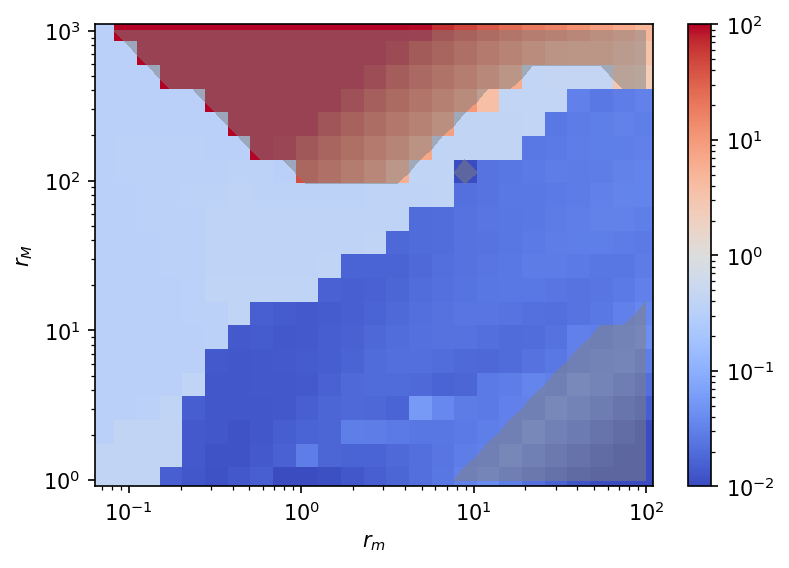

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
p = plt.pcolormesh(rmrange,rMrange,grid,cmap=mpl.colormaps['coolwarm'],norm='log')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlim(rmrange[0]/1.1,rmrange[-1]*1.1)
plt.ylim(rMrange[0]/1.1,rMrange[-1]*1.1)
plt.xlabel(r'$r_m$')
plt.ylabel(r'$r_M$')
plt.clim(1e-2,1e2)
plt.contourf(rmrange,rMrange,flag,1,colors=[[0,0,0,0],[0.5,0.5,0.5,0.5]])

Check an individual run

run_rE0.09474412480179317_rp1000.0_ra1_xi0.005_t11458288_z10_e1.000.zip


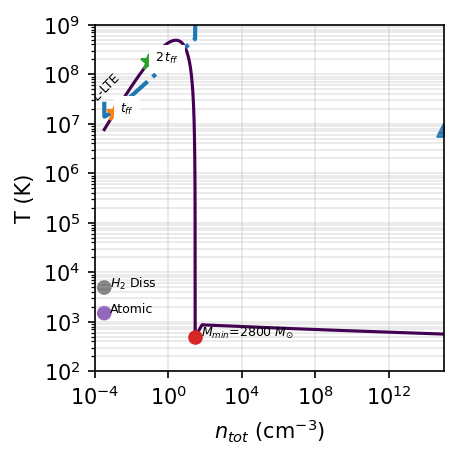

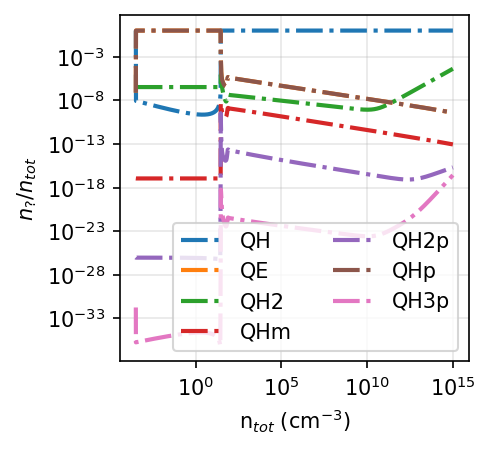

In [10]:
rP = 1000
rE = .1
inds = getInds(rP=rP,rE=rE)
name=labels[inds[0]][inds[1]]
print(name)
rd = RunData(Path('halo',name))
ax = rd.plot()
ax.figure.set_size_inches(3,3)
ax,_ = rd.plotNumberDensities()
ax.figure.set_size_inches(3,3)

Can also run classification algorithm on run (WIP). This tests various attributes about the run (e.g. does it violate the threebody constraint, does it enter isobaric evolution, etc):

In [11]:
rd.classify()
print(f'Run {rd.fname} is a(n) {rd.runtype.name()} run')
rd.flags.long_description()

Run run_rE0.09474412480179317_rp1000.0_ra1_xi0.005_t11458288_z10_e1.000.zip is a(n) Atomic Only run
equil: none
molCool: atomic cooling always dominates
rovibCool: vib only
coolType: ADARKATOM
effCool: min temp before 10 Gyr
subsolar: Mjmin > 1 Msol
highn: ntot(end)>1e9 (ignore equil flag)
hasIso: isobaric evolution disabled
isoThresh: temperature crossed isobaric threshold
smallMass: m<<M
cmb:spectral distortions acceptable
threebody: 2-body interaction timescale dominates
radop: radiative transitions are neglible
protMol: p-H2 cooling dominated H-H2 cooling
h3p: H3p is ignorable
h2opacity: vib H2 line is opaque
nonhydro: SPH model valid
